<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/adasyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Default predictions for lending institution with ADASYN

# Importing Required Libraries

In this step, we import all the essential libraries needed for data analysis, preprocessing, modeling, and evaluation

In [ ]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import ADASYN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading and Exploring the Dataset

i load the loan dataset using pandas and perform basic exploration to understand its structure and content in the (dataset)

   BorrowerID Gender Married     Education Dependant Employment  Income  \
0           1   Male     Yes      Graduate       Yes         No    4583   
1           2   Male     Yes      Graduate        No        Yes    3000   
2           3   Male     Yes  Not graduate        No         No    2583   
3           4   Male      No      Graduate        No         No    6000   
4           5   Male     Yes  Not graduate        No         No    2333   

   LoanAmount  LoanTerm CreditHistory Property   LoanStatus  
0         128       NaN           Yes      Yes      Default  
1          66       NaN           Yes      Yes  Non_Default  
2         120       NaN           Yes      Yes  Non_Default  
3         141       NaN           Yes      Yes  Non_Default  
4          70       NaN           Yes       No  Non_Default  
Shape: (20, 12)
Missing values:
 BorrowerID        0
Gender            0
Married           0
Education         0
Dependant         0
Employment        0
Income            0
Loan

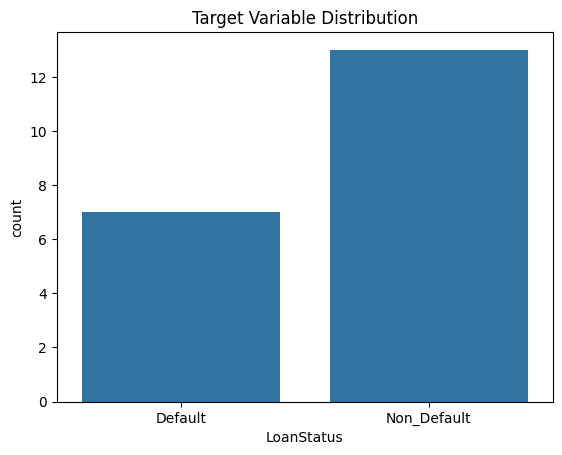

In [ ]:
# Load dataset
df = pd.read_excel('/content/LOANDATASET.xlsx')

# Show first few rows
print(df.head())

# Show shape
print("Shape:", df.shape)

# Show missing values
print("Missing values:\n", df.isnull().sum())
print("\nTarget variable distribution:\n", df['LoanStatus'].value_counts())

# Visualize Target Distribution
sns.countplot(x='LoanStatus', data=df)
plt.title("Target Variable Distribution")
plt.show()


Initial Data Exploration

In [ ]:
#  Initial Exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (20, 12)

Missing values:
 BorrowerID        0
Gender            0
Married           0
Education         0
Dependant         0
Employment        0
Income            0
LoanAmount        0
LoanTerm         20
CreditHistory     0
Property          0
LoanStatus        0
dtype: int64


**Drop Unnecessary Column**

i remove the 'LoanTerm' column from the dataset which helps keep the dataset clean and focused on relevant features

In [ ]:
# Drop the LoanTerm column
df = df.drop(columns=['LoanTerm'])

# Check the dataset again
print(df.head())
print("Shape after dropping column:", df.shape)

   BorrowerID Gender Married     Education Dependant Employment  Income  \
0           1   Male     Yes      Graduate       Yes         No    4583   
1           2   Male     Yes      Graduate        No        Yes    3000   
2           3   Male     Yes  Not graduate        No         No    2583   
3           4   Male      No      Graduate        No         No    6000   
4           5   Male     Yes  Not graduate        No         No    2333   

   LoanAmount CreditHistory Property   LoanStatus  
0         128           Yes      Yes      Default  
1          66           Yes      Yes  Non_Default  
2         120           Yes      Yes  Non_Default  
3         141           Yes      Yes  Non_Default  
4          70           Yes       No  Non_Default  
Shape after dropping column: (20, 11)


*Encode Categorical Variables*

Machine learning models require numerical input, so we need to convert categorical text-based features into numeric form

In [ ]:
# Encode Categorical Variables
categorical_cols = ['Gender', 'Married', 'Education', 'Dependant', 'Employment', 'Property', 'LoanStatus', 'CreditHistory']
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


*Preview Encoded Data*

In [ ]:
df.head()

,BorrowerID,Gender,Married,Education,Dependant,Employment,Income,LoanAmount,CreditHistory,Property,LoanStatus
0,1,1,1,0,1,0,4583,128,1,1,0
1,2,1,1,0,0,1,3000,66,1,1,1
2,3,1,1,1,0,0,2583,120,1,1,1
3,4,1,0,0,0,0,6000,141,1,1,1
4,5,1,1,1,0,0,2333,70,1,0,1


*Separate Features and Target*

In [ ]:
# Split Features and Target
# drop irrelevant ID
X = df.drop(columns=['LoanStatus', 'BorrowerID'])
y = df['LoanStatus']

# Handle Class Imbalance Using ADASYN

In [ ]:
#  Handle Class Imbalance with ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

print("Before resampling:\n", y.value_counts())
print("After resampling:\n", pd.Series(y_resampled).value_counts())

Before resampling:
 LoanStatus
1    13
0     7
Name: count, dtype: int64
After resampling:
 LoanStatus
0    14
1    13
Name: count, dtype: int64


Feature Scaling


In [ ]:
# Scale the Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

 Evaluating Model Performance Using Cross-Validation


In [ ]:
#  Evaluate with Cross-Validation
model = RandomForestClassifier(class_weight='balanced', random_state=42)
scores = cross_val_score(model, X_scaled, y_resampled, cv=5, scoring='f1')

print("Cross-validation F1 scores:", scores)
print("Average F1 Score:", scores.mean())

Cross-validation F1 scores: [0.75       0.85714286 1.         1.         0.8       ]
Average F1 Score: 0.8814285714285715


Hyperparameter Tuning with GridSearchCV for RandomForestClassifier


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_scaled, y_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Best F1 Score: 0.9214285714285715


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_scaled, y_resampled)


RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=42)

# Model Evaluation with Confusion Matrix and Classification Report


In [ ]:
# Split Resampled Data for Evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

# Train the best model on train set
best_model.fit(X_train, y_train)

# Predict on test set
y_pred = best_model.predict(X_test)

#  Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2 1]
 [0 3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



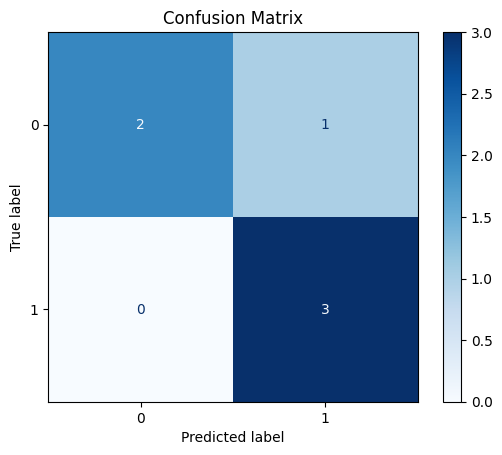

In [ ]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Visualizing Feature Importance


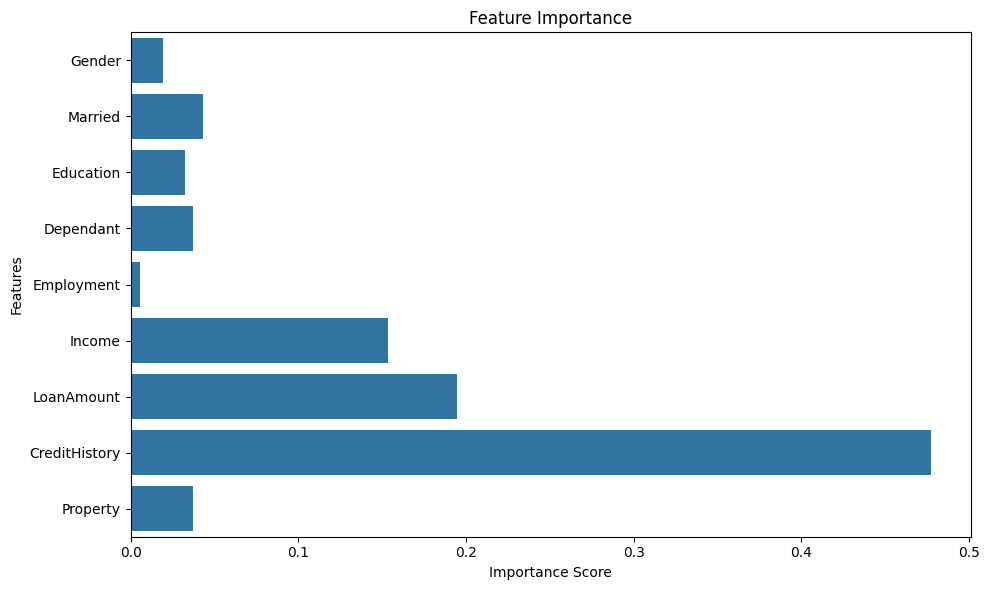

In [ ]:
# Feature Importance
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()